# Object reconstruction (with probe known) with the poisson noise model and its surrogate formulation

In [1]:
import ptychoSampling.farfield.run_methods.utils as utils  
import ptychoSampling.farfield.run_methods.params as params
import dataclasses as dt
import tensorflow as tf
import numpy as np
from ptychoSampling.logger import logger
import matplotlib.pyplot as plt

logger.setLevel("WARNING")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# If set to true, this will reload the simulation (with the custom parameters) saved by simulation.ipynb
# If false, will load new simulation with some default parameters.

reload_simulation = True
base_path = './'

sim_items = utils.getSimulationAndGuesses(default_path_str=base_path, reload_simulation=reload_simulation)

Loaded successfully


In [4]:
sim_items.keys()

dict_keys(['obj', 'probe', 'scan_grid', 'intensities', 'default_obj_guess', 'default_probe_guess'])

0.9999814769712294 7.744173927948239e-05


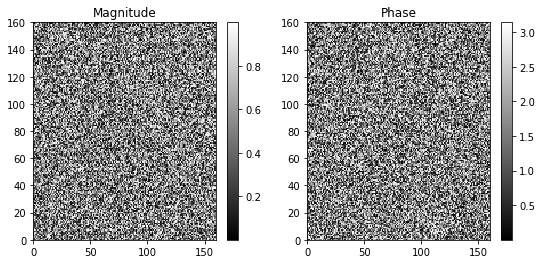

In [5]:
# Default obj guess is a random complex array

print(np.abs(sim_items["default_obj_guess"].array).max(), np.abs(sim_items["default_obj_guess"].array).min())

# Showing juust the object guess
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(sim_items["default_obj_guess"].array), cmap='gray')
plt.title('Magnitude')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(sim_items["default_obj_guess"].array), cmap='gray')
plt.title('Phase')
plt.colorbar()
plt.show()


In [6]:
loss_type_1 = 'poisson'
loss_type_2 = 'poisson_surrogate'
background_level = sim_items['intensities'].max() * 1e-8

### Preconditioned conjugate gradient`

In [7]:
from ptychoSampling.farfield.run_methods.recons_methods import CGReconstructionT

In [20]:
# Supplying the true probe for the probe guess
# the obj_abs_proj=False parameter ensures that we don't use any object constraints

# While the speed of convergence sis different for the two methods, 
# the number of inner CG iterations required (and thus the actual computational cost) is about the same.

recons1 = CGReconstructionT(obj=sim_items['default_obj_guess'],
                           probe=sim_items['probe'],
                           loss_type= loss_type_1,
                           grid= sim_items["scan_grid"],
                           intensities= sim_items["intensities"],
                           obj_array_true= sim_items["obj"].array,
                           reconstruct_probe=False,
                           apply_precond=True,
                           background_level=background_level,
                           obj_abs_proj=False)

recons1.run(200, debug_output_epoch_frequency=20)

Setting background_level to 8.7e-07...
        epoch  train_loss  obj_ls_iters  obj_alpha  obj_error   obj_nlse   r_factor
20         20   -3.44e+06            31    0.00171      0.617      0.428      0.681
40         40   -3.5e+06         69    0.00342      0.472      0.237      0.614
60         60  -3.51e+06        105    0.00342      0.188     0.0361       0.61
80         80  -3.51e+06        142    0.00342      0.113     0.0128      0.597
100        100  -3.51e+06        179    0.00342      0.102     0.0105      0.597
120        120  -3.51e+06        209    0.00342      0.101     0.0102      0.596
140        140  -3.51e+06        251   3.34e-06        0.1     0.0101      0.596
160        160  -3.51e+06        280   0.000856        0.1     0.0101      0.596
180        180  -3.51e+06        313    0.00171        0.1       0.01      0.596
200        200  -3.51e+06        347    0.00342     0.0999       0.01      0.596


In [21]:
recons2 = CGReconstructionT(obj=sim_items['default_obj_guess'],
                           probe=sim_items['probe'],
                           loss_type= loss_type_2,
                           grid= sim_items["scan_grid"],
                           intensities= sim_items["intensities"],
                           obj_array_true= sim_items["obj"].array,
                           reconstruct_probe=False,
                           apply_precond=True,
                           background_level=background_level,
                           obj_abs_proj=False)

recons2.run(200, debug_output_epoch_frequency=20)

kwargs {'background_level': 8.7e-07}
n_levels 100
Setting background_level to 8.7e-07...
Background level 8.7e-07 n_iterations 100
        epoch  train_loss  obj_ls_iters  obj_alpha  obj_error   obj_nlse   r_factor
20         20    -3.4e+06            28    0.00458      0.618      0.439      0.528
40         40  -3.51e+06         62    0.00458      0.308     0.0973      0.591
60         60  -3.51e+06         93    0.00229      0.131     0.0172      0.596
80         80  -3.51e+06        132    0.00114        0.1     0.0101      0.596
100        100  -3.51e+06        166    0.00229     0.0985    0.00974      0.596
120        120  -3.51e+06        201    0.00229     0.0977    0.00957      0.596
140        140  -3.51e+06        235    0.00229     0.0975    0.00955      0.596
160        160  -3.51e+06        279   3.57e-05     0.0975    0.00954      0.596
180        180  -3.51e+06        310    0.00915     0.0975    0.00954      0.596
200        200  -3.51e+06        348    0.00229     0.09

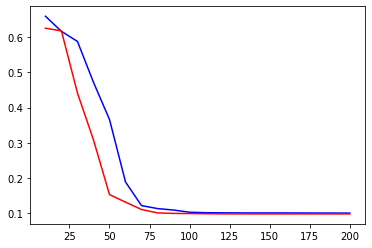

In [22]:
plt.plot(recons1.datalog.dataframe.obj_error.dropna(), color='blue')
plt.plot(recons2.datalog.dataframe.obj_error.dropna(), color='red')

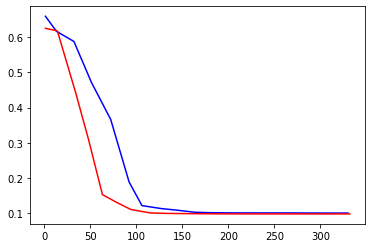

In [24]:
plt.plot(recons1.datalog.dataframe.obj_ls_iters.dropna()[::10], recons1.datalog.dataframe.obj_error.dropna(), color='blue')
plt.plot(recons2.datalog.dataframe.obj_ls_iters.dropna()[::10], recons2.datalog.dataframe.obj_error.dropna(), color='red')

1.1814147 0.01032368


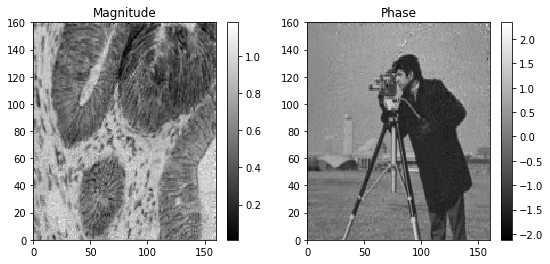

In [25]:
# Reconstructed object

print(np.abs(recons1.obj.array).max(), np.abs(recons1.obj.array).min())

# Showing juust the object guess
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(recons1.obj.array), cmap='gray')
plt.title('Magnitude')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(recons1.obj.array), cmap='gray')
plt.title('Phase')
plt.colorbar()
plt.show()


### Levenberg-Marquardt

In [26]:
from ptychoSampling.farfield.run_methods.recons_methods import LMAReconstructionT

In [27]:
# Supplying the true probe for the probe guess
# the obj_abs_proj=False parameter ensures that we don't use any object constraints
# Changing the "min_cg_tol" parameter changes the required accuracy from the LM update calculation.
# Default min_cg_tol is 0.1, but 0.9 is better for the Poisson model

recons1 = LMAReconstructionT(obj=sim_items['default_obj_guess'],
                           probe=sim_items['probe'],
                           loss_type= loss_type_1,
                           grid= sim_items["scan_grid"],
                           intensities= sim_items["intensities"],
                           obj_array_true= sim_items["obj"].array,
                           reconstruct_probe=False,
                           apply_precond_and_scaling=True,
                           background_level=background_level,
                           obj_abs_proj=False,
                           min_cg_tol=0.9)
recons1.run(200, debug_output_epoch_frequency=20)

Loss init args None
Setting background_level to 8.7e-07...
obj_opt_init_extra_kwargs {}
Extra initial parameters: {'diag_mu_scaling_t': <tf.Tensor 'concat:0' shape=(51200,) dtype=float32>, 'diag_precond_t': <tf.Tensor 'concat:0' shape=(51200,) dtype=float32>, 'grad_norm_regularization_power': 0, 'mu': 1.0, 'name': 'obj_opt', 'min_cg_tol': 0.9, 'stochastic_diag_estimator_type': None, 'stochastic_diag_estimator_iters': 1, 'assert_tolerances': False}
        epoch  train_loss  obj_cg_iters  obj_ls_iters  obj_proj_iters     obj_mu  obj_error   obj_nlse   r_factor
20         20    -3.5e+06           198             0               0     0.0419      0.204     0.0422      0.613
40         40  -3.51e+06        262          0          0      1e-08      0.133     0.0178      0.598
60         60  -3.51e+06        298          0          0    6.4e-07      0.125     0.0157      0.597
80         80  -3.51e+06        318          0          0      1e-08      0.105     0.0111      0.597
100        100

In [28]:
# Supplying the true probe for the probe guess
# the obj_abs_proj=False parameter ensures that we don't use any object constraints

recons2 = LMAReconstructionT(obj=sim_items['default_obj_guess'],
                           probe=sim_items['probe'],
                           loss_type= loss_type_2,
                           grid= sim_items["scan_grid"],
                           intensities= sim_items["intensities"],
                           obj_array_true= sim_items["obj"].array,
                           reconstruct_probe=False,
                           apply_precond_and_scaling=True,
                           background_level=background_level,
                           obj_abs_proj=False, min_cg_tol=0.9)
recons2.run(200, debug_output_epoch_frequency=20)

Loss init args None
kwargs {'background_level': 8.7e-07}
n_levels 100
Setting background_level to 8.7e-07...
Background level 8.7e-07 n_iterations 100
obj_opt_init_extra_kwargs {}
Extra initial parameters: {'diag_mu_scaling_t': <tf.Tensor 'concat:0' shape=(51200,) dtype=float32>, 'diag_precond_t': <tf.Tensor 'concat:0' shape=(51200,) dtype=float32>, 'grad_norm_regularization_power': 0, 'mu': 1.0, 'name': 'obj_opt', 'min_cg_tol': 0.9, 'stochastic_diag_estimator_type': None, 'stochastic_diag_estimator_iters': 1, 'assert_tolerances': False}
        epoch  train_loss  obj_cg_iters  obj_ls_iters  obj_proj_iters     obj_mu  obj_error   obj_nlse   r_factor
20         20   -3.41e+06            49             0               0     0.0625      0.586      0.378      0.487
40         40  -3.51e+06        112          0          0     0.0625      0.206     0.0431      0.589
60         60  -3.51e+06        142          0          0   3.81e-06      0.099    0.00984      0.595
80         80  -3.51e+06

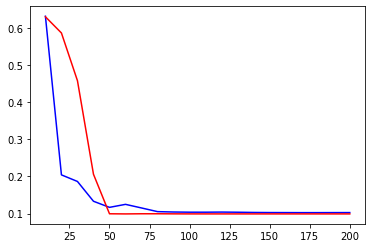

In [29]:
plt.plot(recons1.datalog.dataframe.obj_error.dropna(), color='blue')
plt.plot(recons2.datalog.dataframe.obj_error.dropna(), color='red')

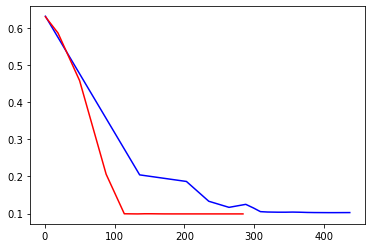

In [30]:
plt.plot(recons1.datalog.dataframe.obj_cg_iters.dropna()[::10], recons1.datalog.dataframe.obj_error.dropna(), color='blue')
plt.plot(recons2.datalog.dataframe.obj_cg_iters.dropna()[::10], recons2.datalog.dataframe.obj_error.dropna(), color='red')

1.2313057 0.016130416


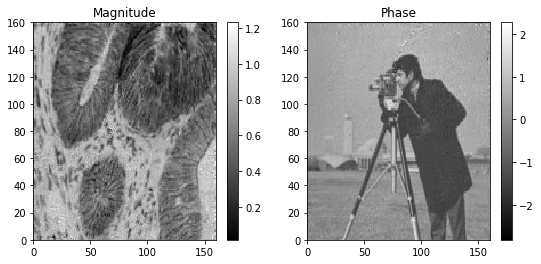

In [31]:
# Reconstructed object

print(np.abs(recons1.obj.array).max(), np.abs(recons1.obj.array).min())

# Showing juust the object guess
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(recons1.obj.array), cmap='gray')
plt.title('Magnitude')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(recons1.obj.array), cmap='gray')
plt.title('Phase')
plt.colorbar()
plt.show()


### ADMM
The penalty parameter ($\beta$) has not been tuned.

In [34]:
from ptychoSampling.farfield.run_methods.admm_methods import SimpleADMMReconstructionT

In [44]:
# Supplying the true probe for the probe guess
# the obj_abs_proj=False parameter ensures that we don't use any object constraints
# Changing the "min_cg_tol" parameter changes the required accuracy from the LM update calculation.
# Default min_cg_tol is 0.1, but 0.9 is better for the Poisson model

recons1 = SimpleADMMReconstructionT(obj=sim_items['default_obj_guess'],
                           probe=sim_items['probe'],
                           loss_type= loss_type_1,
                           beta=0.5,
                           grid= sim_items["scan_grid"],
                           intensities= sim_items["intensities"],
                           obj_array_true= sim_items["obj"].array,
                           reconstruct_probe=False,
                           background_level=background_level,
                           obj_abs_proj=False)
recons1.run(200, debug_output_epoch_frequency=20)

Setting background_level to 8.7e-07...
        epoch  train_loss   ls_iters      alpha  admm_inner_iters  obj_error  lagrangian   r_factor
20         20   -3.28e+06         24       0.29                 1      0.646   -3.42e+06      0.435
40         40  -3.32e+06         63       0.29          1      0.646  -3.46e+06      0.412
60         60  -3.34e+06         98       0.29          1       0.62  -3.48e+06      0.404
80         80  -3.35e+06        130      0.579          1      0.581  -3.49e+06      0.399
100        100  -3.35e+06        160      0.579          1      0.535  -3.49e+06      0.395
120        120  -3.35e+06        190      0.579          1      0.487   -3.5e+06      0.392
140        140  -3.36e+06        220      0.579          1       0.44   -3.5e+06      0.389
160        160  -3.36e+06        250      0.579          1      0.395  -3.51e+06      0.387
180        180  -3.36e+06        280      0.579          1      0.355  -3.51e+06      0.386
200        200  -3.36e+06   

In [45]:
# Supplying the true probe for the probe guess
# the obj_abs_proj=False parameter ensures that we don't use any object constraints
# Changing the "min_cg_tol" parameter changes the required accuracy from the LM update calculation.
# Default min_cg_tol is 0.1, but 0.9 is better for the Poisson model

recons2 = SimpleADMMReconstructionT(obj=sim_items['default_obj_guess'],
                           probe=sim_items['probe'],
                           loss_type= loss_type_2,
                           beta=0.5,
                           grid= sim_items["scan_grid"],
                           intensities= sim_items["intensities"],
                           obj_array_true= sim_items["obj"].array,
                           reconstruct_probe=False,
                           background_level=background_level,
                           obj_abs_proj=False)
recons2.run(200, debug_output_epoch_frequency=20)

kwargs {'dtype': 'float32', 'background_level': 8.7e-07}
n_levels 100
Setting background_level to 8.7e-07...
Background level 8.7e-07 n_iterations 100
        epoch  train_loss   ls_iters      alpha  admm_inner_iters  obj_error  lagrangian   r_factor
20         20   -3.34e+06         26      0.311                 1      0.648   -3.33e+06      0.431
40         40  -3.37e+06         56      0.311          1      0.644  -3.46e+06      0.413
60         60  -3.35e+06         86      0.311          1      0.617  -3.48e+06      0.405
80         80  -3.35e+06        116      0.311          1      0.579  -3.49e+06        0.4
100        100  -3.35e+06        146      0.311          1      0.533  -3.49e+06      0.396
120        120  -3.36e+06        176      0.311          1      0.486   -3.5e+06      0.393
140        140  -3.36e+06        206      0.311          1      0.439   -3.5e+06       0.39
160        160  -3.36e+06        236      0.311          1      0.395  -3.51e+06      0.389
180     

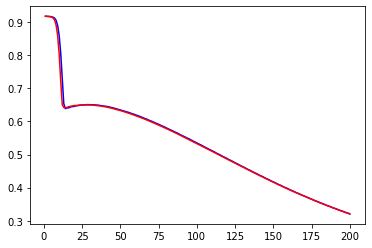

In [46]:
plt.plot(recons1.datalog.dataframe.obj_error.dropna(), color='blue')
plt.plot(recons2.datalog.dataframe.obj_error.dropna(), color='red')

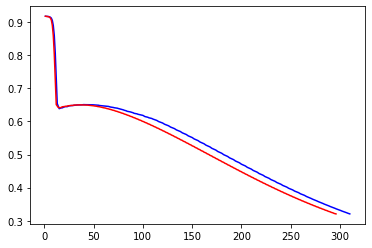

In [47]:
plt.plot(recons1.datalog.dataframe.ls_iters.dropna(), recons1.datalog.dataframe.obj_error.dropna(), color='blue')
plt.plot(recons2.datalog.dataframe.ls_iters.dropna(), recons2.datalog.dataframe.obj_error.dropna(), color='red')